# Neural Network in pure python



In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

### Import training and test set

In [2]:
Z_training = np.loadtxt(fname = 'training_set.txt', delimiter=',')
Z_training.shape

(120, 2)

In [3]:
Z_test = np.loadtxt(fname = 'test_set.txt', delimiter=',')
Z_test.shape

(25, 2)

In [4]:
x_training, y_training = Z_training.T
x_test, y_test = Z_test.T

### Training and test set visualization

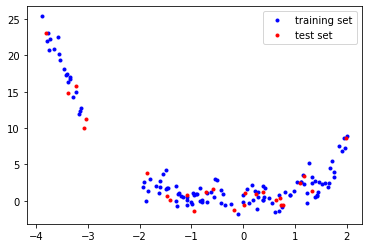

In [5]:
plt.plot(x_training,y_training, 'b.', label = 'training set')
plt.plot(x_test,y_test, 'r.', label = 'test set')
plt.legend()
plt.show()

There is an interval [-3,-2] where x data are missing; this is likely to be the interval where the real test will be done. Also x > 2 could be a good interval to be tested. 

We should see in the end that the predictions of the final trained model in those intervals aren't crazy.

### Define other activation functions

In [6]:
from scipy.special import expit
# expit(x) = 1/(1+exp(-x))
def sigmoid(x):
    return expit(x)

# 1st derivative
#sigmoid_der = lambda x: sigmoid(x) * (1 - sigmoid(x))

def sigmoid_der(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [7]:
# vectorized implementation

def ReLU(x):
    x = x.reshape((len(x),1))
    zeros = np.zeros(x.shape)
    z = np.stack((x,zeros), axis=1)
    return np.max(z, axis=1)

def ReLU_der(x):
    z = np.zeros(x.shape)
    z[x>0] = 1
    return z

In [8]:
# vectorized implementation

def LeakyReLU(x):
    x = x.reshape((len(x),1))
    ones = x*0.1
    z = np.stack((x,ones), axis=1)
    return np.max(z, axis=1)

def LeakyReLU_der(x):
    z = np.ones(x.shape)
    z[x<0] = 0.1
    return z

### Show learned function

In [9]:
def show_forecast_vs_groundtruth(NN, x_test, y_test):
    x_axis = np.linspace(-4,4,4000)
    plt.plot(x_test, [NN.forward(x) for x in x_test], 'b.', label = 'predictions')
    plt.plot(x_test, y_test, '.r', label = 'ground truth')
    plt.plot(x_axis, [NN.forward(x) for x in x_axis], 'g--', lw = 0.7, label =  'learned function' )
    plt.legend()
    plt.show()

## Define NN class with more methods

The idea is to incorporate all the parameters of the training inside the NN, so that then we can implement an automatic grid search with cross validation.

Skelethon  of the class:

```python
class Network():
    
    def __init__(self, N_neurons, act_func, act_der_func, lr, n_epochs, \
                 en_decay=True, lr_final=1e-4, early_stopping = True, tol = 1e-3, \
                 en_penalty=False, penalty=1e-4, en_grad_clipping=True, grad_treshold=10)
    
    def load_weights(self, WBh1, WBh2, WBo)
    
    def save_weights(self)
    
    def forward(self, x, additional_out=False)
    
    def update(self, x, label)
    
    def train(self, x_train, y_train, x_val, y_val, train_log=False, verbose=False)
    
    def evalutate_mean_loss(self, x_test, y_test)
        
    def plot_weights(self)
```

In [10]:
#%% Network class

class Network():
    
    def __init__(self, N_neurons, act_func, act_der_func, lr, n_epochs, \
                 en_decay=True, lr_final=1e-4, early_stopping = True, tol = 1e-3, \
                 en_penalty=False, penalty=1e-4, en_grad_clipping=True, grad_treshold=10):
        
        Ni, Nh1, Nh2, No = N_neurons
        ### WEIGHT INITIALIZATION (Xavier)
        # Initialize hidden weights and biases (layer 1)
        Wh1 = (np.random.rand(Nh1, Ni) - 0.5) * np.sqrt(12 / (Nh1 + Ni))
        Bh1 = np.zeros([Nh1, 1])
        self.WBh1 = np.concatenate([Wh1, Bh1], 1) # Weight matrix including biases
        # Initialize hidden weights and biases (layer 2)
        Wh2 = (np.random.rand(Nh2, Nh1) - 0.5) * np.sqrt(12 / (Nh2 + Nh1))
        Bh2 = np.zeros([Nh2, 1])
        self.WBh2 = np.concatenate([Wh2, Bh2], 1) # Weight matrix including biases
        # Initialize output weights and biases
        Wo = (np.random.rand(No, Nh2) - 0.5) * np.sqrt(12 / (No + Nh2))
        Bo = np.zeros([No, 1])
        self.WBo = np.concatenate([Wo, Bo], 1) # Weight matrix including biases
        
        ### ACTIVATION FUNCTION
        self.act = act_func
        self.act_der = act_der_func
        
        # TRAINING PARAMETERS
        self.lr = lr
        self.n_epochs = n_epochs
        self.en_decay = en_decay
        self.tolerance = tol
        if en_decay == True:
            self.lr_decay = (lr_final / lr)**(1 / n_epochs)
        else:
            self.lr_decay = None
        
        if early_stopping == True:
            self.early_stopping = True
        else:
            self.early_stopping = False
        
        if (en_penalty == 'L1'):
            self.penalty = penalty
            self.penalty_type = 'L1'
        elif (en_penalty == 'L2'):
            self.penalty = penalty
            self.penalty_type = 'L2'
        else:
            self.penalty = None
            self.penalty_type = None
            
        if en_grad_clipping == True:
            self.grad_treshold = grad_treshold
        else:
            self.grad_treshold = None
    
    def load_weights(self, WBh1, WBh2, WBo):
        self.WBh1 = WBh1
        self.WBh2 = WBh2
        self.WBo = WBo
        
    def save_weights(self):
        np.save("WBh1", self.WBh1)
        np.save("WBh2", self.WBh2)
        np.save("WBo", self.WBo)
        
    def forward(self, x, additional_out=False):
        
        # Convert to numpy array
        x = np.array(x)
        
        ### Hidden layer 1
        # Add bias term
        X = np.append(x, 1)
        # Forward pass (linear)
        H1 = np.matmul(self.WBh1, X)
        # Activation function
        Z1 = self.act(H1)
        
        ### Hidden layer 2
        # Add bias term
        Z1 = np.append(Z1, 1)
        # Forward pass (linear)
        H2 = np.matmul(self.WBh2, Z1)
        # Activation function
        Z2 = self.act(H2)
        
        ### Output layer
        # Add bias term
        Z2 = np.append(Z2, 1)
        # Forward pass (linear)
        Y = np.matmul(self.WBo, Z2)
        # NO activation function
        
        if additional_out:
            return Y.squeeze(), Z2
        
        return Y.squeeze()
        
    def update(self, x, label):
        
        # Convert to numpy array
        X = np.array(x)
        
        ### Hidden layer 1
        # Add bias term
        X = np.append(X, 1)
        # Forward pass (linear)
        H1 = np.matmul(self.WBh1, X)
        # Activation function
        Z1 = self.act(H1)
        
        ### Hidden layer 2
        # Add bias term
        Z1 = np.append(Z1, 1)
        # Forward pass (linear)
        H2 = np.matmul(self.WBh2, Z1)
        # Activation function
        Z2 = self.act(H2)
        
        ### Output layer
        # Add bias term
        Z2 = np.append(Z2, 1)
        # Forward pass (linear)
        Y = np.matmul(self.WBo, Z2)
        # NO activation function
        
        # Evaluate the derivative terms
        D1 = Y - label
        D2 = Z2
        D3 = self.WBo[:,:-1]
        D4 = self.act_der(H2)
        D5 = Z1
        D6 = self.WBh2[:,:-1]
        D7 = self.act_der(H1)
        D8 = X
        
        # Layer Error
        Eo = D1
        Eh2 = np.matmul(Eo, D3) * D4
        Eh1 = np.matmul(Eh2, D6) * D7
         
        # Derivative for weight matrices
        dWBo = np.matmul(Eo.reshape(-1,1), D2.reshape(1,-1))
        dWBh2 = np.matmul(Eh2.reshape(-1,1), D5.reshape(1,-1))
        dWBh1 = np.matmul(Eh1.reshape(-1,1), D8.reshape(1,-1))
        
        if self.grad_treshold != None:
            # compute the norm of the whole gradient
            grad_norm = np.linalg.norm(np.concatenate([dWBo.flatten(),dWBh2.flatten(),dWBh1.flatten()]))
            # if the norm exceeds the threshold, we rescale component wise so that the norm is clipped to the treshold
            if grad_norm > self.grad_treshold :
                dWBo = dWBo/grad_norm*self.grad_treshold 
                dWBh1 = dWBh1/grad_norm*self.grad_treshold 
                dWBh2 = dWBh2/grad_norm*self.grad_treshold 
      
        if self.penalty_type == 'L1':
            
            # Compute penalty 
            WBh1_sgn = np.ones(self.WBh1.shape)
            WBh1_sgn[self.WBh1<0] = -1

            WBh2_sgn = np.ones(self.WBh2.shape)
            WBh2_sgn[self.WBh2<0] = -1

            WBo_sgn = np.ones(self.WBo.shape)
            WBo_sgn[self.WBo<0] = -1
        
            # Update the weights
            self.WBh1 -= self.lr * (dWBh1 + self.penalty * WBh1_sgn)
            self.WBh2 -= self.lr * (dWBh2 + self.penalty * WBh2_sgn)
            self.WBo -= self.lr * (dWBo + self.penalty * WBo_sgn)
            
            # Compute the loss
            loss = (Y - label)**2/2 + \
                   self.penalty * (np.abs(self.WBh1).sum() + np.abs(self.WBh2).sum() + np.abs(self.WBo).sum())
            
        elif self.penalty_type == 'L2':
        
            # Update the weights
            self.WBh1 -= self.lr * (dWBh1 + self.penalty * self.WBh1)
            self.WBh2 -= self.lr * (dWBh2 + self.penalty * self.WBh2)
            self.WBo -= self.lr * (dWBo + self.penalty * self.WBo)
            
            # Compute the loss
            loss = (Y - label)**2/2 + \
                   self.penalty *( (self.WBh1**2).sum() + (self.WBh2**2).sum() + (self.WBo**2).sum() )
        
        else: # no penalty case
            
            # Update the weights
            self.WBh1 -= self.lr * dWBh1
            self.WBh2 -= self.lr * dWBh2
            self.WBo -= self.lr * dWBo
            
            # Compute penalty error
            loss = (Y - label)**2/2     
            
        return loss
    
    def train(self, x_train, y_train, x_val, y_val, train_log=False, verbose=False):
    
        if (train_log == True) or (self.early_stopping == True):
            train_loss_log = []
            val_loss_log = []
        if (self.early_stopping == True):
            last_check = 40
        for num_ep in range(self.n_epochs):
            # Learning rate decay
            if self.en_decay:
                self.lr *= self.lr_decay
            # Train single epoch (sample by sample, no batch for now)
            train_loss_vec = [self.update(x, y) for x, y in zip(x_train, y_train)]
            avg_train_loss = np.mean(train_loss_vec)
            # Validation network
            y_val_est = np.array([self.forward(x) for x in x_val])
            avg_val_loss = np.mean((y_val_est - y_val)**2/2) # just mean squared error
            # Log
            train_loss_log.append(avg_train_loss)
            val_loss_log.append(avg_val_loss)
            
            if verbose == True:
                print('Epoch %d - lr: %.5f - Train loss: %.4f - Test loss: %.4f' % \
                      (num_ep + 1, self.lr, avg_train_loss, avg_val_loss))
            
            if self.early_stopping and (num_ep > 100):
                # if the minimum loss of the last 20 epochs is greater than the mean of the previous 20 epochs
                # in a range of tolerance specified, then either stop if the learning is adaptive
                # or adapte the learning rate untill it is smaller or equal to 10^-4
                if np.mean(val_loss_log[-40:-20]) - self.tolerance < np.min(val_loss_log[-20:]):
                    if (not self.en_decay) and (self.lr >= 1e-4): #only case in which we do not stop
                        if num_ep - last_check > 20: #wait at least 20 epochs between adjustment of learning rates
                            if verbose:
                                print("Training is not improving. Reducing by 10 the learning rate.")
                            self.lr = self.lr/10 
                            last_check = num_ep
                        else:
                            continue
                    else:
                        if (not self.en_decay) and num_ep - last_check < 20:
                            continue
                        else:
                            if verbose:
                                print("Training interrupted by early stopping.")
                            break 
                else:
                    continue
            
        if train_log == True:
            return train_loss_log, val_loss_log
    
    
    def evaluate_mean_loss(self, x_test, y_test, save=False):
        y_predicted = np.array([self.forward(x) for x in x_test])
        average_loss = np.mean((y_predicted - y_test)**2/2)
        if save:
            np.savetxt('predictions.txt', y_predicted)
        return average_loss
        
    def plot_weights(self):
    
        fig, axs = plt.subplots(3, 1, figsize=(12,9))
        axs[0].hist(self.WBh1.flatten(), 20)
        axs[0].set_title('First hidden layer weights')
        axs[1].hist(self.WBh2.flatten(), 50)
        axs[1].set_title('Second hidden layer weights')
        axs[2].hist(self.WBo.flatten(), 20)
        axs[2].set_title('Output layer weights')
        #plt.legend()
        #plt.grid()
        plt.tight_layout()
        plt.show()

## L1 penalty term

In the initialization if the flag `en_penalty` is set to `'L1'`, then the L1 penalty is used.

New loss function:
$$ L = \frac{1}{2}(Y-\hat{Y})^2 + \lambda \left(\sum_{i,j}|W_{ij}^{(o)}| + \sum_{i,j}|W_{ij}^{(h1)}| + \sum_{i,j}|W_{ij}^{(h2)}| \right)$$

Thus there is an additional term in the backpropagation. For example:
$$\frac{\partial L}{\partial W_{ij}^{(o)}} = (Y - \hat{Y}) + \lambda \cdot sgn(W_{ij}^{(o)}) $$

## L2 penalty term

In the initialization if the flag `en_penalty` is set to `'L2'`, then the L2 penalty is used.

New loss function:
$$ L = \frac{1}{2}(Y-\hat{Y})^2 + \lambda \left(\sum_{i,j}(W_{ij}^{(o)})^2 + \sum_{i,j}(W_{ij}^{(h1)})^2 + \sum_{i,j}(W_{ij}^{(h2)})^2 \right)$$

Thus there is an additional term in the backpropagation. For example:
$$\frac{\partial L}{\partial W_{ij}^{(o)}} = (Y - \hat{Y}) + 2\lambda \cdot W_{ij}^{(o)}$$

### Gradient clipping

To avoid exploding gradients, if a gradient is greater in absolute value than a certain threshold `grad_tresh`, clip it to the treshold.

Gradient clipping has a severe issue, that is the fact that it is altering the learning rule. This has the positive effect to avoid exploding gradients, but it doesn't hold anymore the convexity property of the loss function, hence for some values of the gradient treshold the training loss oscillates a lot.

In [55]:
# example
grad = np.array([-1,-1000,2000,1,2,3])
print("Initial grad: \n", grad)
# set a treshold
grad_tresh = 10

grad_norm = np.linalg.norm(grad)

if grad_norm > grad_tresh:
    grad_clipped = grad/grad_norm*grad_tresh
print("Clipped grad: \n",grad_clipped)

Initial grad: 
 [   -1 -1000  2000     1     2     3]
Clipped grad: 
 [-4.47212925e-03 -4.47212925e+00  8.94425849e+00  4.47212925e-03
  8.94425849e-03  1.34163877e-02]


## Initialize new NN class passing parameters

In [56]:
# just to see if it works
x_train = x_training
y_train = y_training
x_val = x_test
y_val = y_test

In [228]:
# single choice of parameters
parameters = dict(N_neurons = [1,50,20,1], 
                  act_func = LeakyReLU,
                  act_der_func = LeakyReLU_der, 
                  lr = 0.005,
                  n_epochs = 2000,
                  en_decay = True,
                  lr_final = 1e-4,
                  early_stopping = True,
                  tol = 1e-3,
                  en_penalty = 'L1',
                  penalty = 0.0005,
                  en_grad_clipping = True,
                  grad_treshold = 10)

In [229]:
# pass a dictionary as keyword=argument list to the __init__ function
net = Network(**parameters)

In [230]:
train_loss_log, val_loss_log = net.train(x_train, y_train, x_val, y_val, train_log=True, verbose=True)

Epoch 1 - lr: 0.00499 - Train loss: 22.5750 - Test loss: 11.6073
Epoch 2 - lr: 0.00498 - Train loss: 14.6451 - Test loss: 6.5446
Epoch 3 - lr: 0.00497 - Train loss: 11.9989 - Test loss: 5.5255
Epoch 4 - lr: 0.00496 - Train loss: 9.5924 - Test loss: 4.8249
Epoch 5 - lr: 0.00495 - Train loss: 7.7687 - Test loss: 4.0483
Epoch 6 - lr: 0.00494 - Train loss: 6.0064 - Test loss: 4.0021
Epoch 7 - lr: 0.00493 - Train loss: 4.5105 - Test loss: 3.8558
Epoch 8 - lr: 0.00492 - Train loss: 3.5318 - Test loss: 3.2318
Epoch 9 - lr: 0.00491 - Train loss: 2.8360 - Test loss: 2.9226
Epoch 10 - lr: 0.00490 - Train loss: 2.4251 - Test loss: 2.8208
Epoch 11 - lr: 0.00489 - Train loss: 2.1860 - Test loss: 2.5725
Epoch 12 - lr: 0.00488 - Train loss: 2.0043 - Test loss: 2.4969
Epoch 13 - lr: 0.00487 - Train loss: 1.8668 - Test loss: 2.4521
Epoch 14 - lr: 0.00486 - Train loss: 1.8356 - Test loss: 2.1501
Epoch 15 - lr: 0.00486 - Train loss: 1.8065 - Test loss: 2.0435
Epoch 16 - lr: 0.00485 - Train loss: 1.7914 -

Epoch 130 - lr: 0.00388 - Train loss: 1.0945 - Test loss: 1.2412
Epoch 131 - lr: 0.00387 - Train loss: 1.0970 - Test loss: 1.2228
Epoch 132 - lr: 0.00386 - Train loss: 1.0980 - Test loss: 1.2423
Epoch 133 - lr: 0.00385 - Train loss: 1.0960 - Test loss: 1.2161
Epoch 134 - lr: 0.00385 - Train loss: 1.0913 - Test loss: 1.2137
Epoch 135 - lr: 0.00384 - Train loss: 1.0937 - Test loss: 1.2153
Epoch 136 - lr: 0.00383 - Train loss: 1.0913 - Test loss: 1.2232
Epoch 137 - lr: 0.00382 - Train loss: 1.0863 - Test loss: 1.2075
Epoch 138 - lr: 0.00382 - Train loss: 1.0801 - Test loss: 1.2063
Epoch 139 - lr: 0.00381 - Train loss: 1.0831 - Test loss: 1.2164
Epoch 140 - lr: 0.00380 - Train loss: 1.0781 - Test loss: 1.1776
Epoch 141 - lr: 0.00379 - Train loss: 1.0739 - Test loss: 1.1927
Epoch 142 - lr: 0.00379 - Train loss: 1.0713 - Test loss: 1.1874
Epoch 143 - lr: 0.00378 - Train loss: 1.0721 - Test loss: 1.1690
Epoch 144 - lr: 0.00377 - Train loss: 1.0667 - Test loss: 1.1854
Epoch 145 - lr: 0.00377 -

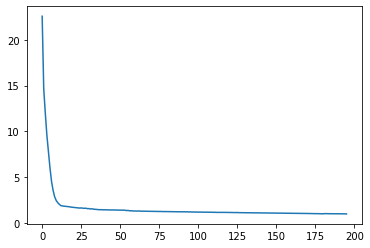

In [231]:
plt.plot(np.arange(len(train_loss_log)), train_loss_log)

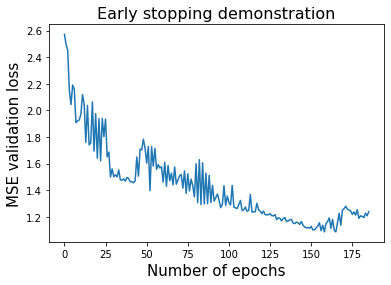

In [238]:
plt.plot(np.arange(len(val_loss_log[10:])), val_loss_log[10:])
plt.xlabel('Number of epochs', fontsize = 15)
plt.ylabel('MSE validation loss', fontsize = 15)
plt.title('Early stopping demonstration', fontsize = 16)
plt.show()

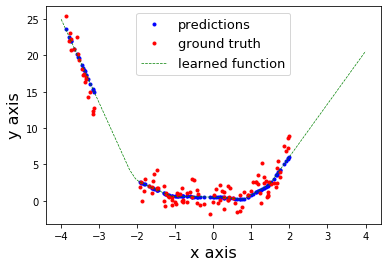

In [239]:
show_forecast_vs_groundtruth(net,x_train, y_train)

Some manual testing to cut down options without grid search and to tune the early stopping algorithm.
Also we can see that the architecture is not influencing that much the performances, whereas I was using a penalty too high.

```python
# starting configuration
parameters = dict(N_neurons = [1,50,5,1], 
                  act_func = LeakyReLU,
                  act_der_func = LeakyReLU_der, 
                  lr = 0.005,
                  n_epochs = 2000,
                  en_decay = True,
                  lr_final = 1e-4,
                  early_stopping = True,
                  tol = 1e-4,
                  en_penalty = 'L2',
                  penalty = 0.05,
                  en_grad_clipping = True,
                  grad_treshold = 10)

```
### Changes in number of neurons

N_neurons = [1,50,5,1]

Epoch 1000 - lr: 0.00071 - Train loss: 2.4792 - Test loss: 1.6337 <br>
Epoch 2000 - lr: 0.00010 - Train loss: 2.3872 - Test loss: 1.5329


N_neurons = [1,50,10,1]

Epoch 1000 - lr: 0.00071 - Train loss: 2.4803 - Test loss: 1.6321 <br>
Epoch 2000 - lr: 0.00010 - Train loss: 2.3891 - Test loss: 1.5353

N_neurons = [1,50,20,1]

Epoch 1000 - lr: 0.00071 - Train loss: 2.4802 - Test loss: 1.6322 <br>
Epoch 2000 - lr: 0.00010 - Train loss: 2.3889 - Test loss: 1.5351

N_neurons = [1,20,20,1]

Epoch 1000 - lr: 0.00071 - Train loss: 2.4802 - Test loss: 1.6330 <br>
Epoch 2000 - lr: 0.00010 - Train loss: 2.3886 - Test loss: 1.5347

N_neurons = [1,100,20,1]

Epoch 1000 - lr: 0.00071 - Train loss: 2.4794 - Test loss: 1.6338 <br>
Epoch 2000 - lr: 0.00010 - Train loss: 2.3876 - Test loss: 1.5333

### Changes in the penalty term

N_neurons = [1,100,20,1] <br>
en_penalty = 'L2' <br>
penalty = 0.1 <br>
                  
Epoch 1000 - lr: 0.00071 - Train loss: 3.7074 - Test loss: 1.8263 <br>
Epoch 2000 - lr: 0.00010 - Train loss: 3.5992 - Test loss: 1.6757

N_neurons = [1,100,20,1] <br>
en_penalty = 'L1' <br>
penalty = 0.01 <br>

Epoch 1000 - lr: 0.00071 - Train loss: 1.1644 - Test loss: 1.2625 <br>
Epoch 1440 - lr: 0.00030 - Train loss: 1.1430 - Test loss: 1.2519 <br>
Training interrupted by early stopping.

N_neurons = [1,100,20,1] <br>
en_penalty = 'L2' <br>
penalty = 0.01 <br>

Epoch 239 - lr: 0.00313 - Train loss: 1.3674 - Test loss: 1.5084
Training interrupted by early stopping.

### Finally found a good range for the penalty term

N_neurons = [1,100,20,1] <br>
en_penalty = 'L2' <br>
penalty = 0.001 <br>

Epoch 1000 - lr: 0.00071 - Train loss: 0.7452 - Test loss: 0.7281 <br>
Epoch 2000 - lr: 0.00010 - Train loss: 0.6805 - Test loss: 0.6667

```python
parameters = dict(N_neurons = [1,100,20,1], 
                  act_func = sigmoid,
                  act_der_func = sigmoid_der, 
                  lr = 0.005,
                  n_epochs = 2000,
                  en_decay = True,
                  lr_final = 1e-4,
                  early_stopping = True,
                  tol = 1e-4,
                  en_penalty = 'L1',
                  penalty = 0.0005,
                  en_grad_clipping = True,
                  grad_treshold = 10)
```

Epoch 1000 - lr: 0.00071 - Train loss: 0.9419 - Test loss: 0.7879 <br>
Epoch 1612 - lr: 0.00021 - Train loss: 0.9186 - Test loss: 0.7788 <br>
Training interrupted by early stopping.

## K-fold cross validation

Idea:
- split training data in K subsets
- use K-1 to train and 1 to validate (like a test set)
- cycle over all K subset and store the validation losses
- rank the hyperparameters used as the mean validation loss

In [11]:
def get_K_folds(x, y, K=5):
    """
    Splits training set x with associated labels y in K (default 5) subsets.
    
    Parameters
    ----------
    x : numpy array, training set 
    y : numpy array, training labels
    K : int, number of folds (optional)
    
    Returns
    -------
    x_subsets : list of K numpy arrays
        Contains the K training subsets
    y_subsets : list of K numpy arrays
        Contains the labels of the K subsets
    """
    m = x.shape[0]
    permutation = np.random.permutation(m)
    x_shuffled = x[permutation]
    y_shuffled = y[permutation]
    
    subset_length = int(m/K)
    x_subsets = []
    y_subsets = []
    for i in range(subset_length-1):
        x_subsets.append(x_shuffled[i*subset_length: (i+1)*subset_length])
        y_subsets.append(y_shuffled[i*subset_length: (i+1)*subset_length])
    
    x_subsets.append(x_shuffled[(K-1)*subset_length:])
    y_subsets.append(x_shuffled[(K-1)*subset_length:])
    
    return x_subsets, y_subsets

In [64]:
x_subsets, y_subsets = get_K_folds(x_training, y_training)

In [12]:
def evaluate_HP(model, params, x_training, y_training, K):
    """
    Train and evaluates a model given some parameters using a K-fold cross validation.
    
    Parameters
    ----------
    model      : class of the predictor
        Must be instantiated as model(**params)
        Must have a "train" method like:
        net.train(x_train, y_train, x_val, y_val, train_log=True, verbose=False)
    params     : dictionary {'model_HP':value}
        hyper-parameters of the model
    x_training : numpy array, training set 
    y_training : training labels
    K          : int, number of folds
    
    """
    Kfolds_val_losses = []
    epochs_length = []
    x_subsets, y_subsets = get_K_folds(x_training, y_training, K)
    
            
    for i in range(K):
        print("Computing fold %d out of %d..."%(i+1,K))
        
        # instantiate new network
        net = model(**params)
        
        # validation sets for this fold
        x_val = x_subsets[i]
        y_val = y_subsets[i]
        
        # training sets
        x_train = np.array([])
        y_train = np.array([])
        for j in range(K):
            if j != i:
                if len(x_train) == 0:
                    x_train = x_subsets[j]
                    y_train = y_subsets[j]
                else:
                    x_train = np.concatenate((x_train, x_subsets[j]), axis=0)
                    y_train = np.concatenate((y_train, y_subsets[j]), axis=0)
        
        
        _, val_loss_log = net.train(x_train, y_train, x_val, y_val, train_log=True, verbose=False)
        # either choose the last element or the smaller (could be a good choice if early stopping is implemented)
        Kfolds_val_losses.append(val_loss_log[-1])
        epochs_length.append(len(val_loss_log)) #record the real number of training epochs

    HP_score = np.array(Kfolds_val_losses).mean()
    HP_deviation = np.array(Kfolds_val_losses).std()
    mean_epochs = int(np.mean(epochs_length))
    return HP_score, HP_deviation, mean_epochs

In [13]:
# single choice of parameters
parameters = dict(N_neurons = [1,20,20,1], 
                  act_func = LeakyReLU,
                  act_der_func = LeakyReLU_der, 
                  lr = 0.01,
                  n_epochs = 50,
                  en_decay = True,
                  lr_final = 0.001,
                  en_penalty = 'L1',
                  penalty = 1e-2,
                  early_stopping = True)

In [97]:
score, dev, mean_epochs = evaluate_HP(Network, parameters,x_training, y_training, K=5)
print(score, dev)

Computing fold 1 out of 5...
Computing fold 2 out of 5...
Computing fold 3 out of 5...
Computing fold 4 out of 5...
Computing fold 5 out of 5...
1.322931882312433 0.45660576003898173


In [14]:
def print_parameters(params):
    print("Parameters: ")
    print('='*75)
    for key in params:
        if (key == 'lr') or (key == 'tol'):
            print(key, '\t \t', params[key])
        else:
            print(key, '\t', params[key])
    print('='*75)

def print_HP_score(params,score,dev):
    print_parameters(params)
    print("Loss: %.4f +/- %.4f"%(score,dev))
    


In [99]:
print_HP_score(parameters, score, dev)

Parameters: 
N_neurons 	 [1, 20, 20, 1]
act_func 	 <function LeakyReLU at 0x7febe5b414d0>
act_der_func 	 <function LeakyReLU_der at 0x7febe5b415f0>
lr 	 	 0.01
n_epochs 	 50
en_decay 	 True
lr_final 	 0.001
en_penalty 	 L1
penalty 	 0.01
early_stopping 	 True
Loss: 1.3229 +/- 0.4566


## Grid Search Cross Validation

In [15]:
def GridSearchCV(model, x_training, y_training, params_comb, K_folds=5):
    """
    Parameters
    ----------
    model      : class of the predictor
        Must be instantiated as model(**params)
        Must have a "train" method like:
        net.train(x_train, y_train, x_val, y_val, train_log, verbose)
    params_comb: list of dictionaries {'model_HP':value}
        all combinations of hyper-parameters to be evaluated
    x_training : numpy array, training set 
    y_training : training labels
    K_folds    : int, number of folds
    
    Returns
    -------
    scoring    : list of all the mean cross-validation losses 
    deviations : list of all the std deviations of the cross-validation losses 
    mean_epochs: list of the mean number of epochs of training for each 
                 configuration of HPs
    """
    import time
    scoring = []
    deviations = []
    mean_epochs = []
    combinations = len(params_comb)
    init_time = time.time()
    for i in range(combinations):
        start = time.time()
        params = params_comb[i]
        HP_score, HP_deviation, epochs = evaluate_HP(model, params, x_training, y_training, K=K_folds)
        scoring.append(HP_score)
        deviations.append(HP_deviation)
        mean_epochs.append(epochs)
        
        print('\nParameters configuration %d out of %d'%(i+1,len(params_comb)))
        print_HP_score(params,HP_score,HP_deviation)
        finish = time.time()
        print('Time for evaluation: %.1f s'%(finish-start))
        time_to_finish = (combinations-i-1)*(finish-init_time)/(i+1)
        
        if time_to_finish > 3600:
            print('Estimated time to finish : %.2f h'%(time_to_finish/3600), '\n')
        elif time_to_finish < 3600 and time_to_finish > 60:
            print('Estimated time to finish : %.2f min'%(time_to_finish/60), '\n')
        else:
            print('Estimated time to finish : %.2f s'%(time_to_finish), '\n')
    return scoring, deviations, mean_epochs

Now we need to explore some portions of the parameter space and then rank the parameters configurations in order of scoring.

Possible/reasonable options for all parameters:

- 3 activation functions (with respective derivatives);
- 1 learning rate: 0.005 -> 0.0001;
- 4 possible numbers of neurons in the first hidden layer, e.g. 10, 20, 50, 100;
- 3 possible numbers of neurons in the second hidden layer, e.g. 10, 20, 50 (but I just want the configurations in which Nh2 <= Nh1, which makes 9 total configs);
- 4 combinations with penalties: L1 with 0.001, L1 with 0.0005, L2 with 0.001, L2 with 0.0005;

Early stopping will be always on. This will enable us to use a great number of epochs (2000) without overfitting.

Total number of combinations:
 $3*9*4 = 108$
 
 I am not sure if exists some library to further automate the enumeration of all the possible parameters, but not having found one, I built my own implementation of that. The goal is to have a list of dictionaries, each of them containing all the keywords needed to specify the model initialization.

In [16]:
import itertools

In [17]:
# we start making list of dictionaries of all the possibilities for every group of keywords

act_func_dict = [{'act_func':sigmoid,'act_der_func':sigmoid_der},
                  {'act_func':ReLU,'act_der_func':ReLU_der},
                  {'act_func':LeakyReLU,'act_der_func':LeakyReLU_der}]

lr_dict = [{'lr': 0.005, 'en_decay':True,'lr_final':0.0001}]

n_epochs_dict = [{'n_epochs':2000, 'early_stopping':True, 'tol':1e-3}]

regularization_dict = [{'en_penalty':'L1', 'penalty':0.001},
                       {'en_penalty':'L1', 'penalty':0.0005},
                       {'en_penalty':'L2', 'penalty':0.001},
                       {'en_penalty':'L2', 'penalty':0.0005}]

N_neurons_dict =[{'N_neurons': [1, 10, 10, 1]},
                 {'N_neurons': [1, 20, 10, 1]},
                 {'N_neurons': [1, 20, 20, 1]},
                 {'N_neurons': [1, 50, 10, 1]},
                 {'N_neurons': [1, 50, 20, 1]},
                 {'N_neurons': [1, 50, 50, 1]},
                 {'N_neurons': [1, 100, 10, 1]},
                 {'N_neurons': [1, 100, 20, 1]},
                 {'N_neurons': [1, 100, 50, 1]}]

The important fact here is that some key-values pairs must be tried only together with other pairs, thus we must treat them as a single case. It's difficult and tedious to explain the code below here, I will just say that it works and there is the possibility to read all the combinations formatted.

In [18]:
def combine_dictionaries(*dictionaries):
    # *var is used to pass an arbitrary number of positional variables 
    global_dict = list(itertools.product(*dictionaries))
    params_list = []
    for i in range(len(global_dict )):
        merged_dict = {}
        for d in global_dict [i]:
            merged_dict = dict(merged_dict, **d)
        params_list.append(merged_dict)
    return params_list

In [19]:
params_list = combine_dictionaries(N_neurons_dict, act_func_dict, lr_dict, n_epochs_dict, regularization_dict)

In [20]:
print("Number of combinations: ", len(params_list))

flag = True #set to True to see all combinations
if flag == True:
    for params in params_list:
        print()
        print_parameters(params)

Number of combinations:  108

Parameters: 
N_neurons 	 [1, 10, 10, 1]
act_func 	 <function sigmoid at 0x7feadaa23710>
act_der_func 	 <function sigmoid_der at 0x7feadaa28560>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.001

Parameters: 
N_neurons 	 [1, 10, 10, 1]
act_func 	 <function sigmoid at 0x7feadaa23710>
act_der_func 	 <function sigmoid_der at 0x7feadaa28560>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.0005

Parameters: 
N_neurons 	 [1, 10, 10, 1]
act_func 	 <function sigmoid at 0x7feadaa23710>
act_der_func 	 <function sigmoid_der at 0x7feadaa28560>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.001

Parameters: 
N_neurons 	 [1, 10, 10, 1]
act_func 	 <function sigmoid at 0x7feadaa23710>
act_der_func 	 <function sigmoid_der at 0x7feadaa2856

lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.0005

Parameters: 
N_neurons 	 [1, 50, 10, 1]
act_func 	 <function sigmoid at 0x7feadaa23710>
act_der_func 	 <function sigmoid_der at 0x7feadaa28560>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.001

Parameters: 
N_neurons 	 [1, 50, 10, 1]
act_func 	 <function sigmoid at 0x7feadaa23710>
act_der_func 	 <function sigmoid_der at 0x7feadaa28560>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.0005

Parameters: 
N_neurons 	 [1, 50, 10, 1]
act_func 	 <function sigmoid at 0x7feadaa23710>
act_der_func 	 <function sigmoid_der at 0x7feadaa28560>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.001

Parameters: 
N_neurons 	 [1, 50, 10, 1]
act_func 	 <function sigmoi


Parameters: 
N_neurons 	 [1, 50, 50, 1]
act_func 	 <function LeakyReLU at 0x7feace8304d0>
act_der_func 	 <function LeakyReLU_der at 0x7feace8305f0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.0005

Parameters: 
N_neurons 	 [1, 50, 50, 1]
act_func 	 <function LeakyReLU at 0x7feace8304d0>
act_der_func 	 <function LeakyReLU_der at 0x7feace8305f0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.001

Parameters: 
N_neurons 	 [1, 50, 50, 1]
act_func 	 <function LeakyReLU at 0x7feace8304d0>
act_der_func 	 <function LeakyReLU_der at 0x7feace8305f0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.0005

Parameters: 
N_neurons 	 [1, 100, 10, 1]
act_func 	 <function sigmoid at 0x7feadaa23710>
act_der_func 	 <function sigmoid_der at 0x7feadaa28560>
lr 	 	 0.005

en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.001

Parameters: 
N_neurons 	 [1, 100, 50, 1]
act_func 	 <function ReLU at 0x7feace830290>
act_der_func 	 <function ReLU_der at 0x7feace8303b0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.0005

Parameters: 
N_neurons 	 [1, 100, 50, 1]
act_func 	 <function ReLU at 0x7feace830290>
act_der_func 	 <function ReLU_der at 0x7feace8303b0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.001

Parameters: 
N_neurons 	 [1, 100, 50, 1]
act_func 	 <function ReLU at 0x7feace830290>
act_der_func 	 <function ReLU_der at 0x7feace8303b0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.0005

Parameters: 
N_neurons 	 [1, 100, 50, 1]
act_func 	 <function Leak

### Using grid search to study single parameters
Before selecting the final parameters I want to shrink their numbers by testing them keeping all other variables fixed. This is useful to make heuristics more evident.

In particular I want to see what changes changing architecture and changing the penalty weight.

In [21]:
# we start making list of dictionaries of all the possibilities for every group of keywords

act_func_dict = [{'act_func':sigmoid,'act_der_func':sigmoid_der},
                  {'act_func':ReLU,'act_der_func':ReLU_der},
                  {'act_func':LeakyReLU,'act_der_func':LeakyReLU_der}]
lr_dict = [{'lr': 0.005, 'en_decay':True,'lr_final':0.0001}]

n_epochs_dict = [{'n_epochs':1000, 'early_stopping':True, 'tol':1e-3}]

regularization_dict = [{'en_penalty':'L2', 'penalty':0.1},
                       {'en_penalty':'L2', 'penalty':0.05},
                       {'en_penalty':'L2', 'penalty':0.01},
                       {'en_penalty':'L2', 'penalty':0.005},
                       {'en_penalty':'L2', 'penalty':0.001},
                       {'en_penalty':'L2', 'penalty':0.0005}]

N_neurons_dict =[{'N_neurons': [1, 10, 10, 1]},
                 {'N_neurons': [1, 20, 10, 1]},
                 {'N_neurons': [1, 20, 20, 1]},
                 {'N_neurons': [1, 50, 10, 1]},
                 {'N_neurons': [1, 50, 20, 1]},
                 {'N_neurons': [1, 50, 50, 1]},
                 {'N_neurons': [1, 100, 10, 1]},
                 {'N_neurons': [1, 100, 20, 1]},
                 {'N_neurons': [1, 100, 50, 1]}]

### Regularization term

In [247]:
regularizations_list = combine_dictionaries(N_neurons_dict[2:3], act_func_dict[:1], lr_dict, n_epochs_dict, regularization_dict)

In [248]:
print("Number of combinations: ", len(regularizations_list))

flag = True #set to True to see all combinations
if flag == True:
    for params in regularizations_list:
        print()
        print_parameters(params)

Number of combinations:  6

Parameters: 
N_neurons 	 [1, 20, 20, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 1000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.1

Parameters: 
N_neurons 	 [1, 20, 20, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 1000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.05

Parameters: 
N_neurons 	 [1, 20, 20, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 1000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.01

Parameters: 
N_neurons 	 [1, 20, 20, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	

In [252]:
%%time
reg_scoring, reg_deviations, reg_mean_epochs = GridSearchCV(Network, x_training, y_training, regularizations_list, K_folds=5)

Computing fold 1 out of 5...
Computing fold 2 out of 5...
Computing fold 3 out of 5...
Computing fold 4 out of 5...
Computing fold 5 out of 5...

Parameters configuration 1 out of 6
Parameters: 
N_neurons 	 [1, 20, 20, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 1000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.1
Loss: 24.5965 +/- 5.5924
Time for evaluation: 13.4 s
Estimated time to finish : 1.12 min 

Computing fold 1 out of 5...
Computing fold 2 out of 5...
Computing fold 3 out of 5...
Computing fold 4 out of 5...
Computing fold 5 out of 5...

Parameters configuration 2 out of 6
Parameters: 
N_neurons 	 [1, 20, 20, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 1000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.0

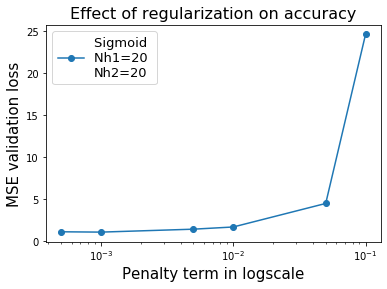

In [264]:
penalties = np.array([0.1,0.05,0.01,0.005,0.001,0.0005])
plt.plot(penalties,reg_scoring,'-o', label = 'Sigmoid \nNh1=20 \nNh2=20')
plt.xscale('log')
plt.xlabel('Penalty term in logscale', fontsize=15)
plt.ylabel('MSE validation loss', fontsize=15)
plt.title('Effect of regularization on accuracy', fontsize=16)
plt.legend(fontsize=13)
plt.show()

### Number of neurons

In [22]:
neurons_list = combine_dictionaries(N_neurons_dict, act_func_dict[:1], lr_dict, n_epochs_dict, regularization_dict[-1:])

In [23]:
print("Number of combinations: ", len(neurons_list))

flag = True #set to True to see all combinations
if flag == True:
    for params in neurons_list:
        print()
        print_parameters(params)

Number of combinations:  9

Parameters: 
N_neurons 	 [1, 10, 10, 1]
act_func 	 <function sigmoid at 0x7feadaa23710>
act_der_func 	 <function sigmoid_der at 0x7feadaa28560>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 1000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.0005

Parameters: 
N_neurons 	 [1, 20, 10, 1]
act_func 	 <function sigmoid at 0x7feadaa23710>
act_der_func 	 <function sigmoid_der at 0x7feadaa28560>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 1000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.0005

Parameters: 
N_neurons 	 [1, 20, 20, 1]
act_func 	 <function sigmoid at 0x7feadaa23710>
act_der_func 	 <function sigmoid_der at 0x7feadaa28560>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 1000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.0005

Parameters: 
N_neurons 	 [1, 50, 10, 1]
act_func 	 <function sigmoid at 0x7feadaa23710>
act_der_func 	 <function sigmoid_der at 0x7feadaa2856

In [269]:
%%time
neurons_scoring, neurons_deviations, neurons_mean_epochs = GridSearchCV(Network, x_training, y_training, neurons_list, K_folds=5)

Computing fold 1 out of 5...
Computing fold 2 out of 5...
Computing fold 3 out of 5...
Computing fold 4 out of 5...
Computing fold 5 out of 5...

Parameters configuration 1 out of 9
Parameters: 
N_neurons 	 [1, 10, 10, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.0005
Loss: 0.8116 +/- 0.1497
Time for evaluation: 141.1 s
Estimated time to finish : 18.82 min 

Computing fold 1 out of 5...
Computing fold 2 out of 5...
Computing fold 3 out of 5...
Computing fold 4 out of 5...
Computing fold 5 out of 5...

Parameters configuration 2 out of 9
Parameters: 
N_neurons 	 [1, 20, 10, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L2
penalty 	

In [27]:
#np.save('neurons_scoring', neurons_scoring) # to make sure of not losing the results of the grid search
neurons_scoring = np.load('neurons_scoring.npy')

In [25]:
#! pip install seaborn
import seaborn as sns

In [62]:
score_matrix = np.zeros((3,4))
index_dict = {10:0, 20:1, 50:2, 100:3}
for i in range(len(N_neurons_dict)):
    Nh1 = N_neurons_dict[i]['N_neurons'][1]
    Nh2 = N_neurons_dict[i]['N_neurons'][2]
    index1 = index_dict[Nh1]
    index2 = index_dict[Nh2]
    score_matrix[index2,index1] = neurons_scoring[i]

In [63]:
help(sns.heatmap)

Help on function heatmap in module seaborn.matrix:

heatmap(data, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)
    Plot rectangular data as a color-encoded matrix.
    
    This is an Axes-level function and will draw the heatmap into the
    currently-active Axes if none is provided to the ``ax`` argument.  Part of
    this Axes space will be taken and used to plot a colormap, unless ``cbar``
    is False or a separate Axes is provided to ``cbar_ax``.
    
    Parameters
    ----------
    data : rectangular dataset
        2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
        is provided, the index/column information will be used to label the
        columns and rows.
    vmin, vmax : floats, optional
        Values to anchor the colormap, otherwise the

In [64]:
score_matrix

array([[0.81155237, 0.79795525, 0.86656025, 0.96049041],
       [0.        , 0.90895348, 0.83250432, 0.79923132],
       [0.        , 0.        , 0.88054038, 0.90454538]])

In [65]:
help(ax.set_ylim)

Help on method set_ylim in module matplotlib.axes._base:

set_ylim(bottom=None, top=None, emit=True, auto=False, *, ymin=None, ymax=None) method of matplotlib.axes._subplots.AxesSubplot instance
    Set the y-axis view limits.
    
    .. ACCEPTS: (bottom: float, top: float)
    
    Parameters
    ----------
    bottom : scalar, optional
        The bottom ylim in data coordinates. Passing *None* leaves the
        limit unchanged.
    
        The bottom and top ylims may be passed as the tuple
        (*bottom*, *top*) as the first positional argument (or as
        the *bottom* keyword argument).
    
    top : scalar, optional
        The top ylim in data coordinates. Passing *None* leaves the
        limit unchanged.
    
    emit : bool, optional
        Whether to notify observers of limit change (default: ``True``).
    
    auto : bool or None, optional
        Whether to turn on autoscaling of the y-axis. *True* turns on,
        *False* turns off (default action), *None* le

In [81]:
help(sns.heatmap)

Help on function heatmap in module seaborn.matrix:

heatmap(data, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)
    Plot rectangular data as a color-encoded matrix.
    
    This is an Axes-level function and will draw the heatmap into the
    currently-active Axes if none is provided to the ``ax`` argument.  Part of
    this Axes space will be taken and used to plot a colormap, unless ``cbar``
    is False or a separate Axes is provided to ``cbar_ax``.
    
    Parameters
    ----------
    data : rectangular dataset
        2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
        is provided, the index/column information will be used to label the
        columns and rows.
    vmin, vmax : floats, optional
        Values to anchor the colormap, otherwise the

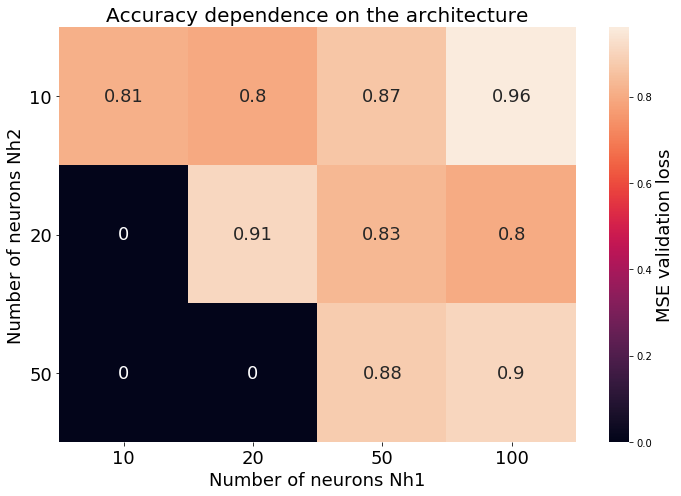

In [80]:
plt.figure(figsize = (10,7))

ax = sns.heatmap(score_matrix, annot = True, annot_kws={'fontsize':18},
                 cbar_kws = {'label' : 'MSE validation loss'})

ax.set_ylim(bottom=3, top=0)

x_index = ['%d'%n for n in [10,20,50,100]]
y_index = ['%d'%n for n in [10,20,50]]

fontdict=dict(fontsize=18)

ax.set_xticklabels(x_index, rotation = 0, **fontdict)
ax.set_xlabel('Number of neurons Nh1', fontsize = 18)

ax.set_yticklabels(y_index, rotation = 0, **fontdict)
ax.set_ylabel('Number of neurons Nh2', fontsize = 18)


ax.figure.axes[-1].yaxis.label.set_size(18)
plt.title("Accuracy dependence on the architecture", fontsize = 20)
plt.tight_layout()
plt.show()

# Final grid search

In [249]:
# we start making list of dictionaries of all the possibilities for every group of keywords

act_func_dict = [{'act_func':sigmoid,'act_der_func':sigmoid_der},
                  {'act_func':ReLU,'act_der_func':ReLU_der},
                  {'act_func':LeakyReLU,'act_der_func':LeakyReLU_der}]

lr_dict = [{'lr': 0.005, 'en_decay':True,'lr_final':0.0001}]

n_epochs_dict = [{'n_epochs':2000, 'early_stopping':True, 'tol':1e-3}]

regularization_dict = [{'en_penalty':'L1', 'penalty':0.001},
                       {'en_penalty':'L1', 'penalty':0.0005},
                       {'en_penalty':'L2', 'penalty':0.001},
                       {'en_penalty':'L2', 'penalty':0.0005}]

N_neurons_dict =[{'N_neurons': [1, 10, 10, 1]},
                 {'N_neurons': [1, 20, 10, 1]},
                 {'N_neurons': [1, 20, 20, 1]},
                 {'N_neurons': [1, 50, 10, 1]},
                 {'N_neurons': [1, 50, 20, 1]},
                 {'N_neurons': [1, 50, 50, 1]},
                 {'N_neurons': [1, 100, 10, 1]},
                 {'N_neurons': [1, 100, 20, 1]},
                 {'N_neurons': [1, 100, 50, 1]}]

In [250]:
params_list = combine_dictionaries(N_neurons_dict, act_func_dict, lr_dict, n_epochs_dict, regularization_dict)

In [251]:
print("Number of combinations: ", len(params_list))

flag = True #set to True to see all combinations
if flag == True:
    for params in params_list:
        print()
        print_parameters(params)

Number of combinations:  108

Parameters: 
N_neurons 	 [1, 10, 10, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.001

Parameters: 
N_neurons 	 [1, 10, 10, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.0005

Parameters: 
N_neurons 	 [1, 10, 10, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.001

Parameters: 
N_neurons 	 [1, 10, 10, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d

tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.0005

Parameters: 
N_neurons 	 [1, 20, 20, 1]
act_func 	 <function LeakyReLU at 0x7febe5b414d0>
act_der_func 	 <function LeakyReLU_der at 0x7febe5b415f0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.001

Parameters: 
N_neurons 	 [1, 20, 20, 1]
act_func 	 <function LeakyReLU at 0x7febe5b414d0>
act_der_func 	 <function LeakyReLU_der at 0x7febe5b415f0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.0005

Parameters: 
N_neurons 	 [1, 50, 10, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.001

Parameters: 
N_neurons 	 [1, 50, 10, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function si

lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.0005

Parameters: 
N_neurons 	 [1, 100, 10, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.001

Parameters: 
N_neurons 	 [1, 100, 10, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.0005

Parameters: 
N_neurons 	 [1, 100, 10, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.001

Parameters: 
N_neurons 	 [1, 100, 1

In [154]:
%%time
scoring, deviations, mean_epochs = GridSearchCV(Network, x_training, y_training, params_list, K_folds=5)

Computing fold 1 out of 5...
Computing fold 2 out of 5...
Computing fold 3 out of 5...
Computing fold 4 out of 5...
Computing fold 5 out of 5...

Parameters configuration 1 out of 108
Parameters: 
N_neurons 	 [1, 10, 10, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.001
Loss: 0.9533 +/- 0.2689
Time for evaluation: 138.1 s
Estimated time to finish : 4.10 h 

Computing fold 1 out of 5...
Computing fold 2 out of 5...
Computing fold 3 out of 5...
Computing fold 4 out of 5...
Computing fold 5 out of 5...

Parameters configuration 2 out of 108
Parameters: 
N_neurons 	 [1, 10, 10, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	

Computing fold 2 out of 5...
Computing fold 3 out of 5...
Computing fold 4 out of 5...
Computing fold 5 out of 5...

Parameters configuration 13 out of 108
Parameters: 
N_neurons 	 [1, 20, 10, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.001
Loss: 0.9037 +/- 0.1697
Time for evaluation: 146.3 s
Estimated time to finish : 3.36 h 

Computing fold 1 out of 5...
Computing fold 2 out of 5...
Computing fold 3 out of 5...
Computing fold 4 out of 5...
Computing fold 5 out of 5...

Parameters configuration 14 out of 108
Parameters: 
N_neurons 	 [1, 20, 10, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.0005
Loss: 0.8422 +/- 0.

Computing fold 2 out of 5...
Computing fold 3 out of 5...
Computing fold 4 out of 5...
Computing fold 5 out of 5...

Parameters configuration 25 out of 108
Parameters: 
N_neurons 	 [1, 20, 20, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.001
Loss: 0.9610 +/- 0.2758
Time for evaluation: 146.3 s
Estimated time to finish : 3.01 h 

Computing fold 1 out of 5...
Computing fold 2 out of 5...
Computing fold 3 out of 5...
Computing fold 4 out of 5...
Computing fold 5 out of 5...

Parameters configuration 26 out of 108
Parameters: 
N_neurons 	 [1, 20, 20, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.0005
Loss: 0.9081 +/- 0.

Computing fold 2 out of 5...
Computing fold 3 out of 5...
Computing fold 4 out of 5...
Computing fold 5 out of 5...

Parameters configuration 37 out of 108
Parameters: 
N_neurons 	 [1, 50, 10, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.001
Loss: 1.0314 +/- 0.4369
Time for evaluation: 110.9 s
Estimated time to finish : 2.56 h 

Computing fold 1 out of 5...
Computing fold 2 out of 5...
Computing fold 3 out of 5...
Computing fold 4 out of 5...
Computing fold 5 out of 5...

Parameters configuration 38 out of 108
Parameters: 
N_neurons 	 [1, 50, 10, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.0005
Loss: 0.8734 +/- 0.

Computing fold 2 out of 5...
Computing fold 3 out of 5...
Computing fold 4 out of 5...
Computing fold 5 out of 5...

Parameters configuration 49 out of 108
Parameters: 
N_neurons 	 [1, 50, 20, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.001
Loss: 0.9768 +/- 0.2956
Time for evaluation: 178.8 s
Estimated time to finish : 2.09 h 

Computing fold 1 out of 5...
Computing fold 2 out of 5...
Computing fold 3 out of 5...
Computing fold 4 out of 5...
Computing fold 5 out of 5...

Parameters configuration 50 out of 108
Parameters: 
N_neurons 	 [1, 50, 20, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.0005
Loss: 0.8712 +/- 0.

Computing fold 2 out of 5...
Computing fold 3 out of 5...
Computing fold 4 out of 5...
Computing fold 5 out of 5...

Parameters configuration 61 out of 108
Parameters: 
N_neurons 	 [1, 50, 50, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.001
Loss: 1.1264 +/- 0.7031
Time for evaluation: 163.0 s
Estimated time to finish : 1.66 h 

Computing fold 1 out of 5...
Computing fold 2 out of 5...
Computing fold 3 out of 5...
Computing fold 4 out of 5...
Computing fold 5 out of 5...

Parameters configuration 62 out of 108
Parameters: 
N_neurons 	 [1, 50, 50, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.0005
Loss: 0.8821 +/- 0.

Computing fold 2 out of 5...
Computing fold 3 out of 5...
Computing fold 4 out of 5...
Computing fold 5 out of 5...

Parameters configuration 73 out of 108
Parameters: 
N_neurons 	 [1, 100, 10, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.001
Loss: 0.9303 +/- 0.2458
Time for evaluation: 139.6 s
Estimated time to finish : 1.25 h 

Computing fold 1 out of 5...
Computing fold 2 out of 5...
Computing fold 3 out of 5...
Computing fold 4 out of 5...
Computing fold 5 out of 5...

Parameters configuration 74 out of 108
Parameters: 
N_neurons 	 [1, 100, 10, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.0005
Loss: 0.8565 +/- 

Computing fold 2 out of 5...
Computing fold 3 out of 5...
Computing fold 4 out of 5...
Computing fold 5 out of 5...

Parameters configuration 85 out of 108
Parameters: 
N_neurons 	 [1, 100, 20, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.001
Loss: 0.9637 +/- 0.4440
Time for evaluation: 126.0 s
Estimated time to finish : 49.87 min 

Computing fold 1 out of 5...
Computing fold 2 out of 5...
Computing fold 3 out of 5...
Computing fold 4 out of 5...
Computing fold 5 out of 5...

Parameters configuration 86 out of 108
Parameters: 
N_neurons 	 [1, 100, 20, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.0005
Loss: 0.8157 +

Computing fold 2 out of 5...
Computing fold 3 out of 5...
Computing fold 4 out of 5...
Computing fold 5 out of 5...

Parameters configuration 97 out of 108
Parameters: 
N_neurons 	 [1, 100, 50, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.001
Loss: 1.0226 +/- 0.3462
Time for evaluation: 271.5 s
Estimated time to finish : 24.14 min 

Computing fold 1 out of 5...
Computing fold 2 out of 5...
Computing fold 3 out of 5...
Computing fold 4 out of 5...
Computing fold 5 out of 5...

Parameters configuration 98 out of 108
Parameters: 
N_neurons 	 [1, 100, 50, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function sigmoid_der at 0x7febf1ad14d0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.0005
Loss: 0.8886 +

For 16 combinations <br>
CPU times: user 34min 25s, sys: 1.38 s, total: 34min 27s <br>
Wall time: 34min 30s

For 108 combinations <br>
Expected time 3h 53 min


In [155]:
np.save('HP_scoring', scoring) # to make sure of not losing the results of the grid search
np.save('HP_deviations', deviations) 
np.save('mean_epochs', mean_epochs) 

In [156]:
scoring = np.load('HP_scoring.npy')
deviations = np.load('HP_deviations.npy')
mean_epochs = np.load('mean_epochs.npy')

In [157]:
# if there are some trainings in which the gradient exploded, take care of them
nan_mask = np.isnan(scoring)
print('Worst finite result: ', np.max(scoring[~nan_mask]))
nan_substitute = np.max(scoring[~nan_mask])
scoring[nan_mask] = nan_substitute

Worst finite result:  1.4249548143922763


In [158]:
# my metric to choose the best model
composite_loss = scoring + 2*deviations

In [159]:
best_params = params_list[np.argmin(composite_loss)]
best_n_epochs = mean_epochs[np.argmin(composite_loss)]

In [160]:
print_HP_score(score=scoring[np.argmin(composite_loss)], 
               dev = deviations[np.argmin(composite_loss)], 
               params=best_params)

Parameters: 
N_neurons 	 [1, 20, 10, 1]
act_func 	 <function ReLU at 0x7febe5b41290>
act_der_func 	 <function ReLU_der at 0x7febe5b413b0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.001
Loss: 0.8550 +/- 0.0770


In [161]:
# if the early stopping was used, in the final training don't use it 
#but train for the mean number of epochs used in the cross validation
if 'early_stopping' in best_params.keys():
    best_params['early_stopping'] = False
    best_params['n_epochs'] = best_n_epochs

In [162]:
print_HP_score(score=scoring[np.argmin(composite_loss)], 
               dev = deviations[np.argmin(composite_loss)], 
               params=best_params)

Parameters: 
N_neurons 	 [1, 20, 10, 1]
act_func 	 <function ReLU at 0x7febe5b41290>
act_der_func 	 <function ReLU_der at 0x7febe5b413b0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 599
early_stopping 	 False
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.001
Loss: 0.8550 +/- 0.0770


## Final training of the best model

In [240]:
best_model = Network(**best_params)

In [241]:
train_loss_log, test_loss_log = best_model.train(x_training, y_training, x_test, y_test, train_log=True, verbose=True)

Epoch 1 - lr: 0.00497 - Train loss: 24.3351 - Test loss: 14.0724
Epoch 2 - lr: 0.00494 - Train loss: 15.6072 - Test loss: 7.3569
Epoch 3 - lr: 0.00490 - Train loss: 12.9046 - Test loss: 5.9168
Epoch 4 - lr: 0.00487 - Train loss: 10.5506 - Test loss: 4.8476
Epoch 5 - lr: 0.00484 - Train loss: 8.4245 - Test loss: 4.2048
Epoch 6 - lr: 0.00481 - Train loss: 6.5327 - Test loss: 3.5463
Epoch 7 - lr: 0.00478 - Train loss: 4.8299 - Test loss: 3.8091
Epoch 8 - lr: 0.00475 - Train loss: 3.6776 - Test loss: 3.2593
Epoch 9 - lr: 0.00471 - Train loss: 2.8648 - Test loss: 2.7049
Epoch 10 - lr: 0.00468 - Train loss: 2.3791 - Test loss: 2.5763
Epoch 11 - lr: 0.00465 - Train loss: 2.0631 - Test loss: 2.3773
Epoch 12 - lr: 0.00462 - Train loss: 1.9372 - Test loss: 2.2780
Epoch 13 - lr: 0.00459 - Train loss: 1.7602 - Test loss: 2.1786
Epoch 14 - lr: 0.00456 - Train loss: 1.7331 - Test loss: 2.0854
Epoch 15 - lr: 0.00453 - Train loss: 1.7385 - Test loss: 1.9075
Epoch 16 - lr: 0.00450 - Train loss: 1.6662 

Epoch 131 - lr: 0.00213 - Train loss: 1.1457 - Test loss: 1.3606
Epoch 132 - lr: 0.00211 - Train loss: 1.1476 - Test loss: 1.3525
Epoch 133 - lr: 0.00210 - Train loss: 1.1445 - Test loss: 1.3500
Epoch 134 - lr: 0.00208 - Train loss: 1.1432 - Test loss: 1.3483
Epoch 135 - lr: 0.00207 - Train loss: 1.1397 - Test loss: 1.3531
Epoch 136 - lr: 0.00206 - Train loss: 1.1418 - Test loss: 1.3455
Epoch 137 - lr: 0.00204 - Train loss: 1.1364 - Test loss: 1.3436
Epoch 138 - lr: 0.00203 - Train loss: 1.1382 - Test loss: 1.3414
Epoch 139 - lr: 0.00202 - Train loss: 1.1359 - Test loss: 1.3401
Epoch 140 - lr: 0.00200 - Train loss: 1.1304 - Test loss: 1.3445
Epoch 141 - lr: 0.00199 - Train loss: 1.1338 - Test loss: 1.3381
Epoch 142 - lr: 0.00198 - Train loss: 1.1291 - Test loss: 1.3400
Epoch 143 - lr: 0.00197 - Train loss: 1.1269 - Test loss: 1.3396
Epoch 144 - lr: 0.00195 - Train loss: 1.1266 - Test loss: 1.3378
Epoch 145 - lr: 0.00194 - Train loss: 1.1256 - Test loss: 1.3360
Epoch 146 - lr: 0.00193 -

Epoch 261 - lr: 0.00091 - Train loss: 1.0137 - Test loss: 1.2061
Epoch 262 - lr: 0.00090 - Train loss: 1.0133 - Test loss: 1.2058
Epoch 263 - lr: 0.00090 - Train loss: 1.0131 - Test loss: 1.2055
Epoch 264 - lr: 0.00089 - Train loss: 1.0131 - Test loss: 1.2051
Epoch 265 - lr: 0.00089 - Train loss: 1.0124 - Test loss: 1.2048
Epoch 266 - lr: 0.00088 - Train loss: 1.0124 - Test loss: 1.2043
Epoch 267 - lr: 0.00087 - Train loss: 1.0119 - Test loss: 1.2040
Epoch 268 - lr: 0.00087 - Train loss: 1.0115 - Test loss: 1.2037
Epoch 269 - lr: 0.00086 - Train loss: 1.0110 - Test loss: 1.2036
Epoch 270 - lr: 0.00086 - Train loss: 1.0110 - Test loss: 1.2030
Epoch 271 - lr: 0.00085 - Train loss: 1.0102 - Test loss: 1.2029
Epoch 272 - lr: 0.00085 - Train loss: 1.0100 - Test loss: 1.2026
Epoch 273 - lr: 0.00084 - Train loss: 1.0100 - Test loss: 1.2021
Epoch 274 - lr: 0.00084 - Train loss: 1.0094 - Test loss: 1.2018
Epoch 275 - lr: 0.00083 - Train loss: 1.0086 - Test loss: 1.2018
Epoch 276 - lr: 0.00082 -

Epoch 389 - lr: 0.00039 - Train loss: 0.9764 - Test loss: 1.1729
Epoch 390 - lr: 0.00039 - Train loss: 0.9759 - Test loss: 1.1730
Epoch 391 - lr: 0.00039 - Train loss: 0.9758 - Test loss: 1.1727
Epoch 392 - lr: 0.00039 - Train loss: 0.9752 - Test loss: 1.1728
Epoch 393 - lr: 0.00038 - Train loss: 0.9755 - Test loss: 1.1723
Epoch 394 - lr: 0.00038 - Train loss: 0.9750 - Test loss: 1.1723
Epoch 395 - lr: 0.00038 - Train loss: 0.9751 - Test loss: 1.1717
Epoch 396 - lr: 0.00038 - Train loss: 0.9743 - Test loss: 1.1720
Epoch 397 - lr: 0.00037 - Train loss: 0.9742 - Test loss: 1.1718
Epoch 398 - lr: 0.00037 - Train loss: 0.9742 - Test loss: 1.1714
Epoch 399 - lr: 0.00037 - Train loss: 0.9738 - Test loss: 1.1714
Epoch 400 - lr: 0.00037 - Train loss: 0.9736 - Test loss: 1.1712
Epoch 401 - lr: 0.00036 - Train loss: 0.9734 - Test loss: 1.1709
Epoch 402 - lr: 0.00036 - Train loss: 0.9731 - Test loss: 1.1708
Epoch 403 - lr: 0.00036 - Train loss: 0.9727 - Test loss: 1.1710
Epoch 404 - lr: 0.00036 -

Epoch 519 - lr: 0.00017 - Train loss: 0.9526 - Test loss: 1.1634
Epoch 520 - lr: 0.00017 - Train loss: 0.9525 - Test loss: 1.1632
Epoch 521 - lr: 0.00017 - Train loss: 0.9524 - Test loss: 1.1633
Epoch 522 - lr: 0.00017 - Train loss: 0.9523 - Test loss: 1.1632
Epoch 523 - lr: 0.00016 - Train loss: 0.9521 - Test loss: 1.1632
Epoch 524 - lr: 0.00016 - Train loss: 0.9520 - Test loss: 1.1634
Epoch 525 - lr: 0.00016 - Train loss: 0.9519 - Test loss: 1.1631
Epoch 526 - lr: 0.00016 - Train loss: 0.9517 - Test loss: 1.1633
Epoch 527 - lr: 0.00016 - Train loss: 0.9516 - Test loss: 1.1633
Epoch 528 - lr: 0.00016 - Train loss: 0.9515 - Test loss: 1.1630
Epoch 529 - lr: 0.00016 - Train loss: 0.9514 - Test loss: 1.1632
Epoch 530 - lr: 0.00016 - Train loss: 0.9513 - Test loss: 1.1629
Epoch 531 - lr: 0.00016 - Train loss: 0.9512 - Test loss: 1.1631
Epoch 532 - lr: 0.00015 - Train loss: 0.9510 - Test loss: 1.1631
Epoch 533 - lr: 0.00015 - Train loss: 0.9510 - Test loss: 1.1627
Epoch 534 - lr: 0.00015 -

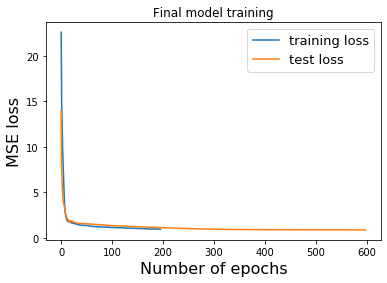

In [234]:
plt.plot(np.arange(len(train_loss_log)), train_loss_log, label ='training loss')
plt.plot(np.arange(len(test_loss_log)), test_loss_log, label ='test loss')
plt.legend(fontsize=13)
plt.xlabel('Number of epochs', fontsize = 16)
plt.ylabel('MSE loss', fontsize = 16)
plt.title('Final model training')
plt.show()

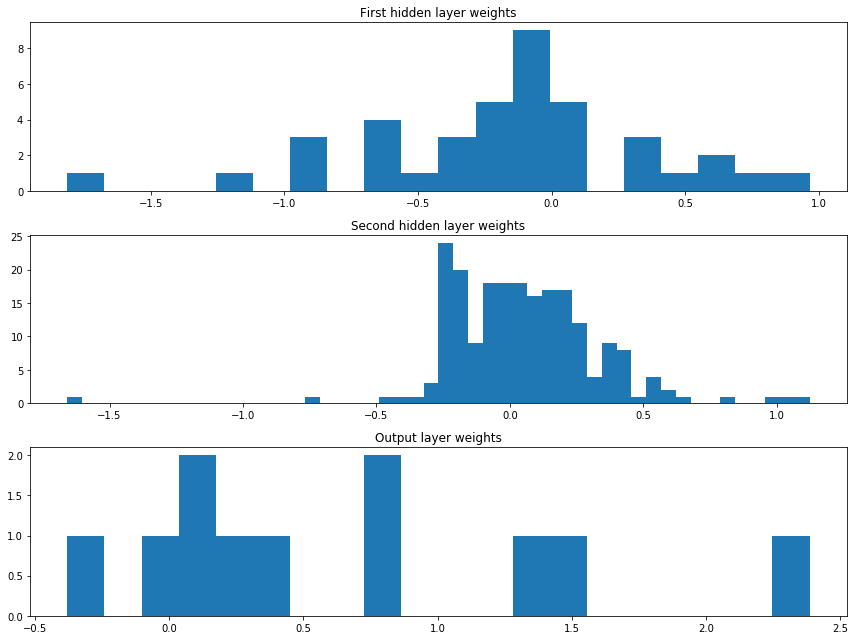

In [206]:
best_model.plot_weights()

In [212]:
def show_forecast_vs_groundtruth(NN, x_test, y_test):
    x_axis = np.linspace(-4,4,4000)
    plt.plot(x_test, [NN.forward(x) for x in x_test], 'b.', label = 'predictions')
    plt.plot(x_test, y_test, '.r', label = 'ground truth')
    plt.plot(x_axis, [NN.forward(x) for x in x_axis], 'g--', lw = 0.7, label =  'learned function' )
    plt.xlabel('x axis', fontsize=16)
    plt.ylabel('y axis', fontsize=16)
    plt.legend(fontsize=13)
    plt.show()

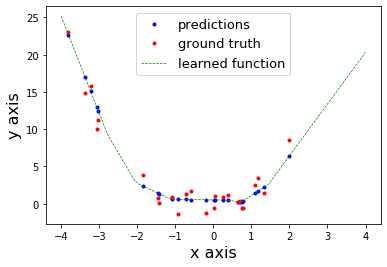

In [213]:
show_forecast_vs_groundtruth(best_model,x_test, y_test)

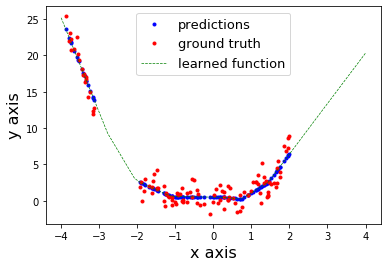

In [214]:
show_forecast_vs_groundtruth(best_model,x_train, y_train)

In [209]:
import pickle

In [210]:
# Save parameters
with open("dict.txt", "wb") as file: 
    pickle.dump(best_params, file)

In [211]:
# Save weights
best_model.save_weights()

# Other finalists

In [218]:
import pandas as pd
params_list = np.array(params_list)
params_list = params_list.reshape((-1,1))
scoring = scoring.reshape((-1,1))
deviations = deviations.reshape((-1,1))
composite_loss = scoring + 2*deviations
data = np.stack((params_list,scoring,deviations,composite_loss), axis=1).reshape((-1,4))
df = pd.DataFrame(data=data, columns=['parameters','loss','dev','score'])
df_best = df.sort_values(by='score', ascending=True)[:5] #best 5 functions
best_configs = df_best.to_numpy()
for i in range(len(best_configs)):
    print_HP_score(params=best_configs[i,0], score=best_configs[i,1], dev=best_configs[i,2])
    print()

Parameters: 
N_neurons 	 [1, 20, 10, 1]
act_func 	 <function ReLU at 0x7febe5b41290>
act_der_func 	 <function ReLU_der at 0x7febe5b413b0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 599
early_stopping 	 False
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.001
Loss: 0.8550 +/- 0.0770

Parameters: 
N_neurons 	 [1, 100, 50, 1]
act_func 	 <function ReLU at 0x7febe5b41290>
act_der_func 	 <function ReLU_der at 0x7febe5b413b0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L2
penalty 	 0.001
Loss: 0.8259 +/- 0.1020

Parameters: 
N_neurons 	 [1, 50, 50, 1]
act_func 	 <function ReLU at 0x7febe5b41290>
act_der_func 	 <function ReLU_der at 0x7febe5b413b0>
lr 	 	 0.005
en_decay 	 True
lr_final 	 0.0001
n_epochs 	 2000
early_stopping 	 True
tol 	 	 0.001
en_penalty 	 L1
penalty 	 0.0005
Loss: 0.7505 +/- 0.1527

Parameters: 
N_neurons 	 [1, 100, 50, 1]
act_func 	 <function sigmoid at 0x7febf1acbb90>
act_der_func 	 <function si

It seems that the first 3 positions are all occupied by ReLU activation functions with different numers of neurons.